In [1]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error,r2_score
from scipy import stats
from scipy.stats import pearsonr

from utils import *

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid')

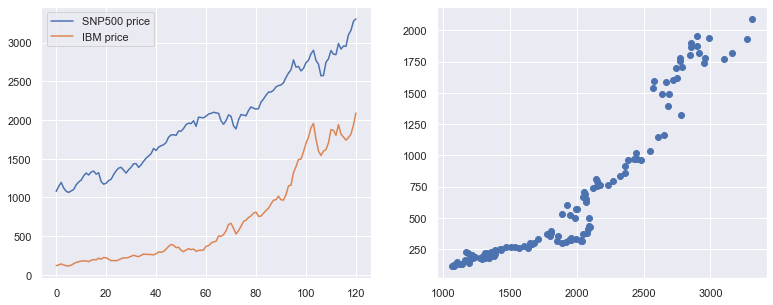

In [2]:
amzn_data = pd.read_csv('../Data/AMZN.csv',parse_dates =['Date'])
snp_data = pd.read_csv('../Data/GSPC.csv',parse_dates=['Date'])

snp_data['Price'] = (snp_data.High + snp_data.Low)*0.5
amzn_data['Price'] = (amzn_data.High + amzn_data.Low)*0.5

fig, ax = plt.subplots(1,2,figsize=(13,5))

snp_data['Price'].plot(label = 'SNP500 price',ax=ax[0])
amzn_data['Price'].plot(label = 'IBM price',ax=ax[0])

X,y = snp_data['Price'].values,amzn_data.Price.values

ax[0].legend()

plt.scatter(snp_data['Price'],amzn_data['Price']);

1. модифікована експонента: $y=\alpha\beta^x+\gamma$
2. крива Гомперця: $y=e^{\alpha\beta^x+\gamma}$
3. логістична крива: $y=\frac{1}{\alpha\beta^x+\gamma}$


Завдання: Побудова нелінійної регресії

* (A) Використовуючи комп'ютерне програмне забезпечення для виконання регресійних
розрахунків, а саме метод трьох точок
𝑥 = 𝑟𝑚, 𝑦 = 𝑟𝑝
оцініть за допомогою нелінійних регресії (1-3) параметри $\alpha$ і $\beta$ для компанії.
* (B) Зробіть порівняльну характеристику для всіх моделей;
Модель | $R^2  | r |  F$
* (C) Оберіть найкращу з моделей і для неї проведіть повний статистичний аналіз.
* (D) Зробіть прогноз на наступний місяць, якщо ринок підніметься на 20% від попереднього
місяця, та побудуйте довірчий інтервал.

In [3]:
def modified_exp(x,alpha,beta,gamma):
    return alpha * np.power(beta,x) + gamma

def gompertz_curve(x,alpha,beta,gamma):
    return np.exp(alpha*np.power(beta,x)+gamma)

def log_curve(x,alpha,beta,gamma):
    return 1/(alpha*beta**x+gamma)

Метод трьох точок для оцінки $\alpha, \beta, \gamma$

In [4]:
class ThreePointsEstimator(BaseEstimator):
    @staticmethod
    def f_statistic(y,y_pred):
        n=y.shape[0]
        R_2 = r2_score(y,y_pred)
        return (R_2*(n-2))/((1-R_2))
    
    @staticmethod
    def split_data(data):
        n = data.shape[0]
        if n%3==0:
            return data[:n//3],data[n//3:2*n//3],data[2*n//3:]           
        elif n%2==1:
            return data[:n//3],data[n//3:2*n//3+1],data[2*n//3+1:]
        else:
            return data[:n//3+1],data[n//3+1:2*n//3+1],data[2*n//3+1:]
    
    def _estimate_alpha(self):
        return (self.y3-self.y2)/(np.power(self.beta_,self.t3)-np.power(self.beta_,self.t2))
    
    def _estimate_beta(self):

        delta = (self.t2-self.t1)
        k = np.log((self.y3-self.y2)/(self.y2-self.y1))
        return np.exp(k/delta)
    
    def _estimate_gamma(self):
        return self.y1 - self.alpha_*self.beta_**self.t1
    
    def __init__(self):
        super(ThreePointsEstimator,self).__init__()
    
    
    def sample_median(self,x):
        if not len(x)%2:
            return x[len(x)//2+1]
        else:
            return 0.5*(x[len(x)//2]+x[len(x)//2+1])
    
    
    def fit(self,X,y=None):
        self.n = X.shape[0]
        
        set1,set2,set3 = ThreePointsEstimator.split_data(y)
#         x1,x2,x3 = ThreePointsEstimator.split_data(np.arange(1,self.n+1))
        x1,x2,x3 = ThreePointsEstimator.split_data(X)
        
#         self.t1,self.t2,self.t3 = np.median(x1),np.median(x2),np.median(x3)
#         self.y1,self.y2,self.y3 = np.median(set1),np.median(set2), np.median(set3)
        self.t1,self.t2,self.t3 = self.sample_median(x1),self.sample_median(x2),self.sample_median(x3)
        self.y1,self.y2,self.y3 = self.sample_median(set1),self.sample_median(set2),self.sample_median(set3)
            
#         print(self.t1,self.t2,self.t3)
        self.beta_ = self._estimate_beta()
        self.alpha_ = self._estimate_alpha() 
        self.gamma_ = self._estimate_gamma()
        
        return self
        
    def coef_(self):
        return self.alpha_,self.beta_,self.gamma_
    
data_dicts = []

1. модифікована експонента: $y=\alpha\beta^x+\gamma$

model coefficients: 
	alpha=1.0917, beta=1.0026, gamma=176.5054
model characteristics: 
	r=0.8350,R^2=0.1182,F=15.9472


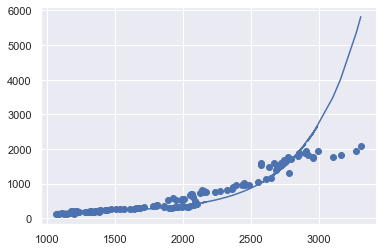

In [5]:
three_points_estimator = ThreePointsEstimator().fit(X,y)
alpha,beta,gamma = three_points_estimator.coef_()
y_hat = modified_exp(X,alpha,beta,gamma)

r,r_sq,f_val = pearsonr(y,y_hat)[0],r2_score(y,y_hat),ThreePointsEstimator.f_statistic(y,y_hat)


plt.scatter(X,y)
plt.plot(X,y_hat)

data_dicts.append({'Модель':'$\alpha* \beta^x$','$r$':r,'$R^2$':r_sq,'$F_{val}$':f_val})
print(f'model coefficients: \n\talpha={alpha:.4f}, beta={beta:.4f}, gamma={gamma:.4f}\nmodel characteristics: \n\tr={r:.4f},R^2={r_sq:.4f},F={f_val:.4f}')
y_hat_mod = y_hat
mr_alpha,mr_beta,mr_gamma = alpha,beta,gamma

2. крива Гомперця: $y=e^{\alpha\beta^x+\gamma}$

$y=e^{\alpha\beta^x+\gamma} \Leftrightarrow ln(y)=\alpha\beta^x+\gamma$

model coefficients: 
	alpha=0.1017, beta=1.0012, gamma=4.8948
model characteristics: 
	r=0.6511,R^2=-4.5782,F=-97.6671


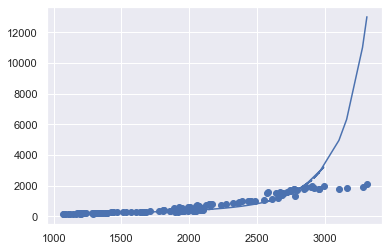

In [6]:
three_points_estimator = ThreePointsEstimator().fit(X,np.log(y))
alpha,beta,gamma = three_points_estimator.coef_()
y_hat = gompertz_curve(X,alpha,beta,gamma)

r,r_sq,f_val = pearsonr(y,y_hat)[0],r2_score(y,y_hat),ThreePointsEstimator.f_statistic(y,y_hat)

plt.scatter(X,y)
plt.plot(X,y_hat)

data_dicts.append({'Модель':'$\alpha* \beta^x$','$r$':r,'$R^2$':r_sq,'$F_{val}$':f_val})
print(f'model coefficients: \n\talpha={alpha:.4f}, beta={beta:.4f}, gamma={gamma:.4f}\nmodel characteristics: \n\tr={r:.4f},R^2={r_sq:.4f},F={f_val:.4f}')

3. логістична крива: $y=\frac{1}{\alpha\beta^x+\gamma}$

$y=\frac{1}{\alpha\beta^x+\gamma} \Leftrightarrow \frac{1}{y}=\alpha\beta^x+\gamma$

model coefficients: 
	alpha=0.0493, beta=0.9999, gamma=-0.0406
model characteristics: 
	r=0.3206,R^2=-48.3038,F=-116.5864


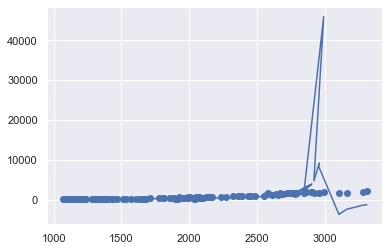

In [7]:
three_points_estimator = ThreePointsEstimator().fit(X,1/y)
alpha,beta,gamma = three_points_estimator.coef_()
y_hat = log_curve(X,alpha,beta,gamma)

r,r_sq,f_val = pearsonr(y,y_hat)[0],r2_score(y,y_hat),ThreePointsEstimator.f_statistic(y,y_hat)

plt.scatter(X,y)
plt.plot(X,y_hat)

data_dicts.append({'Модель':'$\alpha* \beta^x$','$r$':r,'$R^2$':r_sq,'$F_{val}$':f_val})
print(f'model coefficients: \n\talpha={alpha:.4f}, beta={beta:.4f}, gamma={gamma:.4f}\nmodel characteristics: \n\tr={r:.4f},R^2={r_sq:.4f},F={f_val:.4f}')

In [8]:
x = pd.DataFrame.from_records(data_dicts)

Порівняльна характеристика для всіх моделей:

|    | Модель   |      $r$ |      $R^2$ |   $F_{val}$ |
|---:|:---------|---------:|-----------:|------------:|
|  0 | $\alpha\beta^x+\gamma$          | 0.834981 |  0.118174 |    15.947235 |
|  1 | $e^{\alpha\beta^x+\gamma}$       | 0.651084 | -4.578242   |   -97.667113  |
|  2 | $\frac{1}{\alpha*\beta^x+\gamma}$          | 0.320649  |  -48.303825  |   -116.586394   |

(C) Оберіть найкращу з моделей і для неї проведіть повний статистичний аналіз

In [9]:
print(f'Розглядаємо мультипликативну модель з параметрами alpha={mr_alpha:.8f}, beta={mr_beta:.4f}, gamma={mr_gamma:.4f}')

Розглядаємо мультипликативну модель з параметрами alpha=1.09172028, beta=1.0026, gamma=176.5054


Перевіримо, чи є модель значущою:
1. $H_0:\alpha=\beta=\gamma=0;$ <br>
$H_1$:$\exists x: x\in\{\alpha,\beta\}: x\neq0$

In [10]:
f_value = F_val(y,y_hat_mod)
f_critical = stats.f.ppf(q=1-0.025,dfn=1, dfd=X.shape[0]-2)

sign,msg = evaluate_hypothesis(f_value,f_critical)

print(f'F_value = {ThreePointsEstimator().f_statistic(y,y_hat_mod):.4f} {sign} {f_critical:.4f} = F_crit. {msg}')

F_value = 15.9472 < 5.1534 = F_crit. hypothesis must be examined further


Можемо зробити висновок, що модель є значущою,але відмічаємо дуже маленьке F

(D) Зробіть прогноз на наступний місяць, якщо ринок підніметься на 20% від попереднього місяця, та побудуйте довірчий інтервал.

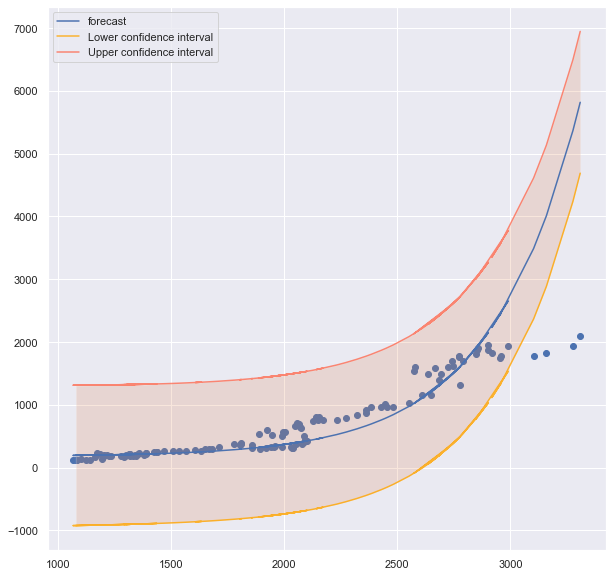

In [11]:
l,u = confidence_interval_final(X,y,y_hat_mod)
d = calc_delta(X,y,y_hat_mod,i=2)
plt.figure(figsize=(10,10))

plt.plot(X,y_hat_mod,label='forecast')
plt.scatter(X,y)

plt.plot(X, l,alpha=0.8,color='orange',label='Lower confidence interval')
plt.plot(X, u,alpha=0.75,c='tomato',label='Upper confidence interval')

plt.fill_between(X,l,u,alpha=0.2)
plt.legend();

### Forecast seems kinda inadequate

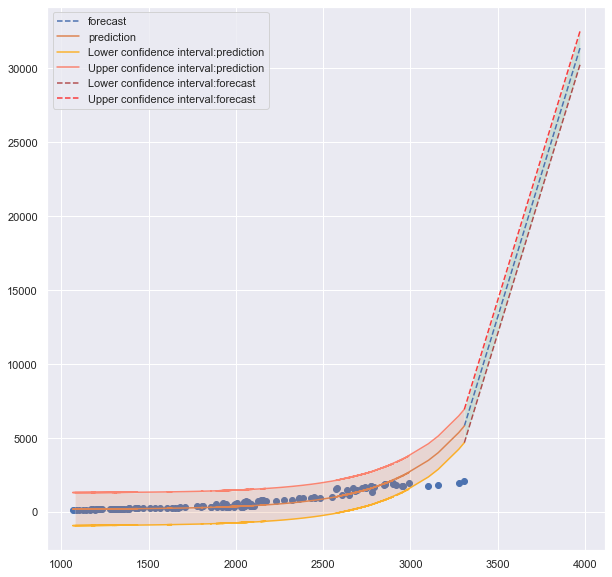

In [12]:
x_forecast = np.linspace(X[-1],1.2*X[-1],num=2)
y_hat_forecast = modified_exp(x_forecast,mr_alpha,mr_beta,mr_gamma)
l_forecast,u_forecast = y_hat_forecast-d,y_hat_forecast+d
plt.figure(figsize=(10,10))
plt.plot(x_forecast,y_hat_forecast,'--',label='forecast')
plt.plot(X,y_hat_mod,label='prediction')
plt.scatter(X,y)

plt.plot(X, l,alpha=0.8,color='orange',label='Lower confidence interval:prediction')
plt.plot(X, u,alpha=0.75,c='tomato',label='Upper confidence interval:prediction')

plt.fill_between(X,l,u,alpha=0.2)
plt.plot(x_forecast, l_forecast,'--',alpha=0.8,color='brown',label='Lower confidence interval:forecast')
plt.plot(x_forecast, u_forecast,'--',alpha=0.75,c='red',label='Upper confidence interval:forecast')

plt.fill_between(x_forecast,l_forecast,u_forecast,alpha=0.2)
plt.legend();